In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats
from sklearn import linear_model, datasets, svm, metrics
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
import urllib2
from bs4 import BeautifulSoup
import numpy as np
%matplotlib inline


In [15]:
train = pd.read_csv('train.csv')
train_sample = train.sample(train.shape[0]/2)
test = pd.read_csv('test.csv')

In [16]:
def remove_nas(dataframe, percent):
    null_data = dataframe.isnull().sum()
    data_to_remove = null_data[null_data > dataframe.shape[0]*percent].index.tolist()
    dataframe.drop(data_to_remove,1, inplace=True)
    return dataframe

In [17]:
def int_data(dataframe):
    data_type = dataframe.dtypes
    int_columns_1 = data_type[data_type=='int64'].index.tolist()
    int_columns_2 = data_type[data_type=='float64'].index.tolist()
    int_columns = int_columns_1 + int_columns_2
    int_dataframe = dataframe[int_columns]
    
    int_list = []
    cat_list = []
    for i in int_dataframe:
        if len(set(int_dataframe[i].values)) > 16:
            int_list.append(i)
        else:
            cat_list.append(i)
    int_dataframe = int_dataframe[int_list]
    return int_dataframe, cat_list

In [18]:
def process_data(dataframe):
    dataframe['TotalSF'] = dataframe['1stFlrSF'] + dataframe['2ndFlrSF']+ dataframe['TotalBsmtSF']
    dataframe.drop(['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF'],1, inplace=True)
    return dataframe

def graph_processed_data(dataframe):
    var = [e for e in dataframe.columns.values.tolist() if e not in ('Id', 'SalePrice')]
    num_col = dataframe[var].shape[1]
    graph_dimension = int(round(math.sqrt(num_col))) +1

    f, ax = plt.subplots(graph_dimension, graph_dimension,figsize=(18,12))
    plt.subplots_adjust( hspace=0.3 )
    plt.subplots_adjust( wspace=0.04 )

    y = dataframe['SalePrice']
    counter = 0

    list_of_predictors =[]
    
    independent_var = dataframe[var]

    for i in range(graph_dimension):
        for j in range(graph_dimension):
            ax[i][j].get_yaxis().set_ticks([])
            ax[i][j].get_xaxis().set_ticks([])
            if counter >= num_col:
                continue
            else:
                x = independent_var.iloc[:, counter]
                ax[i][j].scatter(x,y)
                ax[i][j].set_title(independent_var.columns.values[counter])
            
                slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
            
                if r_value**2 > 0.3:
                    list_of_predictors.append(independent_var.columns.values[counter])
                counter = counter + 1

    final_int_train = independent_var[list_of_predictors]
    return list_of_predictors, dataframe, final_int_train


In [19]:
def categorical_data(dataframe):
    dtype = dataframe.dtypes
    categories = dtype[dtype == 'object'].index.tolist()
    category_dataframe = dataframe[categories]
    return category_dataframe

In [20]:
def graph_processed_cat_data(dataframe, train, cat_list):

    num_col = dataframe.shape[1] - 1 
    cat_list.append('SalePrice')
    dataframe[cat_list] = train[cat_list]
    cols = list(dataframe)
    cols.insert(len(dataframe), cols.pop(cols.index('SalePrice')))
    dataframe = dataframe.ix[:, cols]
    num_col = dataframe.shape[1] - 1 
    graph_dimension = int(round(math.sqrt(num_col))) +1

    f, ax = plt.subplots(graph_dimension, graph_dimension,figsize=(18,12))
    plt.subplots_adjust( hspace=0.3 )
    plt.subplots_adjust( wspace=0.04 )

    counter = 0

    sig_list =[]
    
    for i in range(graph_dimension):
        for j in range(graph_dimension):
            ax[i][j].get_yaxis().set_ticks([])
            ax[i][j].get_xaxis().set_ticks([])
            if counter >= num_col:
                continue
            else:
                df = dataframe.iloc[: , [counter,-1]].groupby(dataframe.columns[counter]).median().sort_values(['SalePrice'], ascending = [0])
                df.plot.bar(ax=ax[i,j])
                ax[i,j].legend_.remove()
                ax[i][j].get_yaxis().set_ticks([])
                ax[i][j].get_xaxis().set_ticks([])


                d = dataframe.iloc[:, [counter, -1]]
                dummy = pd.get_dummies(d)
                for c in dummy.iloc[:, 1:]:
                    neg = dummy.loc[dummy[c] == 0]['SalePrice'].tolist()
                    pos = dummy.loc[dummy[c] == 1]['SalePrice'].tolist()
                    t, p = stats.ttest_ind(neg, pos, equal_var=False)
                    if p <= 0.0005:
                        sig_list.append(c)

                counter = counter + 1
    dummy = pd.get_dummies(dataframe)
    final_cat_train = dummy[sig_list]
    return sig_list, final_cat_train

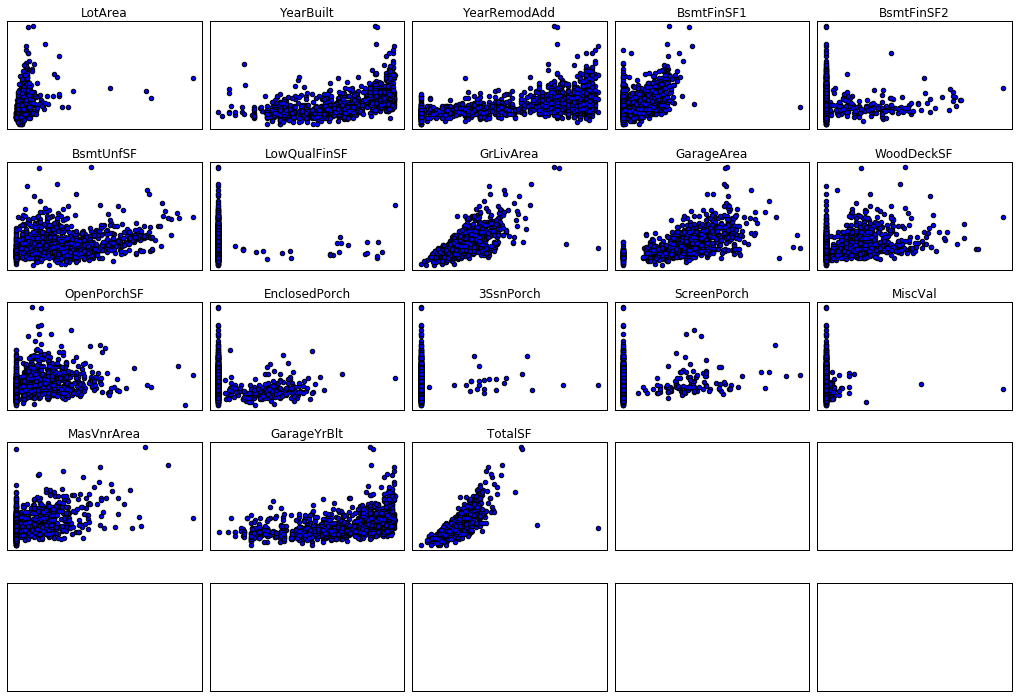

In [21]:
no_na_train = remove_nas(train, .10)
numerical_train, cat_list = int_data(no_na_train)
process_train = process_data(numerical_train)
list_of_predictors_train, train, final_int_train = graph_processed_data(process_train)

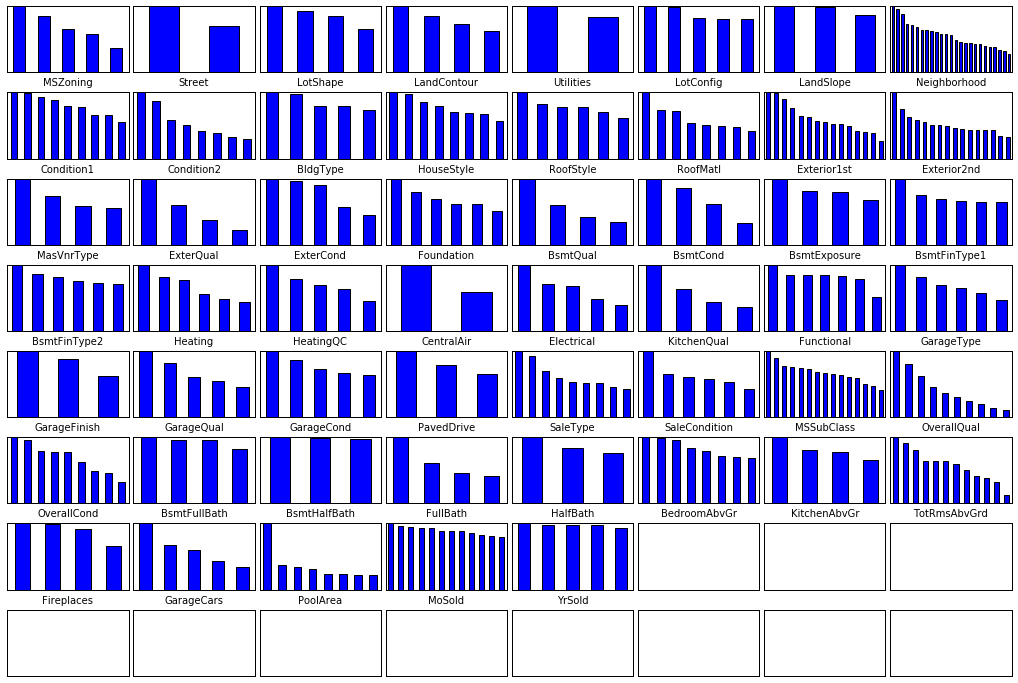

In [22]:
cat = categorical_data(no_na_train)
sig, category= graph_processed_cat_data(cat, no_na_train, cat_list)

In [23]:
no_na_test = remove_nas(test, .10)
numerical_test, num_cat_list = int_data(no_na_test)
process_test = process_data(numerical_test)
cat_test = categorical_data(no_na_test)
cat_test = pd.get_dummies(cat_test)
cat_test_final = cat_test[sig]
final_test = pd.concat([process_test,cat_test_final], axis = 1)


In [24]:
final_train = pd.concat([final_int_train,category], axis = 1)


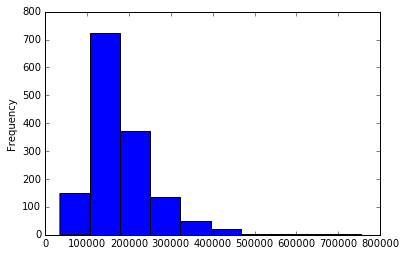

In [48]:
train['SalePrice'].plot.hist()

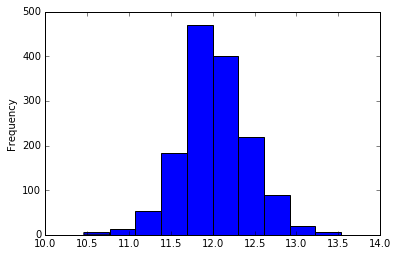

In [49]:
np.log(train['SalePrice']).plot.hist()

0.84236292229


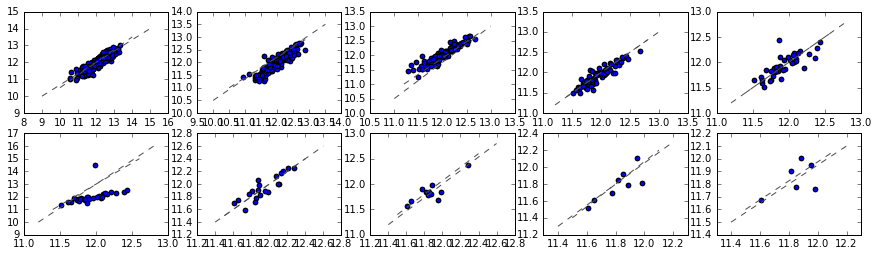

In [26]:
from sklearn import linear_model
x_train, x_test, y_train, y_test = train_test_split(final_train.values, np.log(train['SalePrice'].as_matrix()), test_size=0.3)
k_fold = StratifiedKFold(y_train.ravel(), n_folds = 10)

lr = linear_model.LinearRegression()
lr.fit(x_train,y_train.ravel().T)


times=2

f, ax = plt.subplots(2,5,figsize=(15, 4))

for i in range(times):
    counter = 0
    for train_indx, test_indx in k_fold:
        val_train_x, val_train_y = x_train[train_indx], y_train[train_indx]
        val_test_x, val_test_y = x_train[test_indx], y_train[test_indx]
        lr.fit(val_train_x, val_train_y.ravel().T)
        y_pred = lr.predict(val_test_x)
        ax[counter/5][counter % 5].scatter(val_test_y, y_pred)
        ax[counter/5][counter % 5].plot(ax[counter/5][counter % 5].get_xlim(), ax[counter/5][counter % 5].get_ylim(), ls="--", c=".3")
        counter += 1
print lr.score(x_test, y_test)                           

0.842911117157


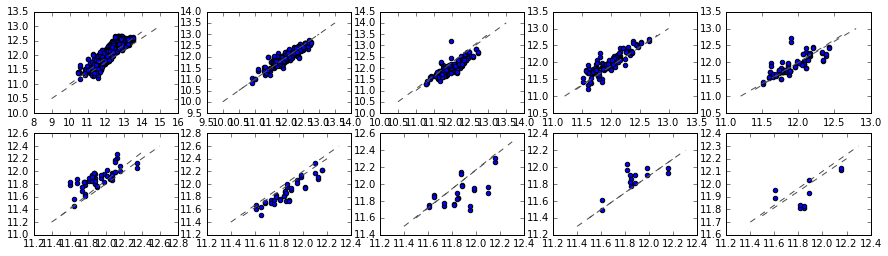

In [28]:
x_train, x_test, y_train, y_test = train_test_split(final_train.values, np.log(train['SalePrice'].as_matrix()), test_size=0.3)
k_fold = StratifiedKFold(y_train.ravel(), n_folds=10)

rfr = RandomForestRegressor()
rfr.fit(x_train,y_train.ravel().T)


times=2

f, ax = plt.subplots(2,5,figsize=(15, 4))

for i in range(times):
    counter = 0
    for train_indx, test_indx in k_fold:
        val_train_x, val_train_y =x_train[train_indx], y_train[train_indx]
        val_test_x, val_test_y = x_train[test_indx], y_train[test_indx]
        rfr.fit(val_train_x, val_train_y.ravel().T)
        y_pred = rfr.predict(val_test_x)
        ax[counter/5][counter % 5].scatter(val_test_y, y_pred)
        ax[counter/5][counter % 5].plot(ax[counter/5][counter % 5].get_xlim(), ax[counter/5][counter % 5].get_ylim(), ls="--", c=".3")
        counter += 1

print rfr.score(x_test, y_test)                           


0.884413848745


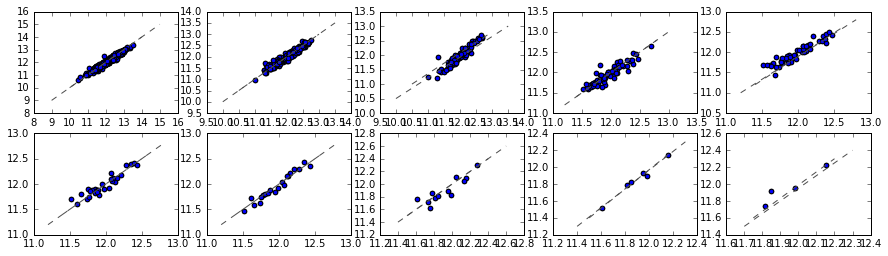

In [40]:
x_train, x_test, y_train, y_test = train_test_split(final_train.values, np.log(train['SalePrice'].as_matrix()), test_size=0.3)
k_fold = StratifiedKFold(y_train.ravel(), n_folds=10)

gbr = GradientBoostingRegressor()
gbr.fit(x_train,y_train.ravel().T)


times=2

f, ax = plt.subplots(2,5,figsize=(15, 4))

for i in range(times):
    counter = 0
    for train_indx, test_indx in k_fold:
        val_train_x, val_train_y =x_train[train_indx], y_train[train_indx]
        val_test_x, val_test_y = x_train[test_indx], y_train[test_indx]
        rfr.fit(val_train_x, val_train_y.ravel().T)
        y_pred = gbr.predict(val_test_x)
        ax[counter/5][counter % 5].scatter(val_test_y, y_pred)
        ax[counter/5][counter % 5].plot(ax[counter/5][counter % 5].get_xlim(), ax[counter/5][counter % 5].get_ylim(), ls="--", c=".3")
        counter += 1

print gbr.score(x_test, y_test)         

In [367]:
#pred_t_int = rfr.predict(process_test[list_of_predictors_train])
#pred_t_cat = gnb.predict(cat_test_final)
#pred_t = rfr.predict(final_test)
#output_int = process_test[['Id']]
#output_int['SalePrice']=pred_t_int
#output_cat = process_test[['Id']]
#output_cat['SalePrice'] = pred_t_cat
#output['SalePrice'] = pred_t
#final_output = process_test[['Id']]
#final_output['SalePrice'] = (output_int['SalePrice'] + output_cat['SalePrice'])/2
#final_output['SalePrice'] = output['SalePrice']
#final_output = final_output.applymap(abs)
#final_output.to_csv("prediction.csv",index=False)

In [86]:
soup = BeautifulSoup(urllib2.urlopen(urllib2.Request("https://www.zillow.com/homes/recently_sold/MA/26_rid/0-599988_price/0-2224_mp/globalrelevanceex_sort/43.777044,-69.573669,40.256473,-73.797913_rect/7_zm/")).read())
all_url = []
for i in range(1,20):
    soup = BeautifulSoup(urllib2.urlopen(urllib2.Request("https://www.zillow.com/homes/recently_sold/MA/26_rid/0-599988_price/0-2224_mp/globalrelevanceex_sort/43.773077,-68.733215,40.25228,-74.638367_rect/7_zm/" + str(i) + "_p/")).read())
    for a in soup.find_all('a', href = True):
        if 'homedetails' in a['href']:
            all_url.append(a['href'])

/home/jen/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [87]:
dic={}
for url in all_url:
    soup = BeautifulSoup(urllib2.urlopen(urllib2.Request('https://www.zillow.com//' + str(url))).read())
    columns = soup.find_all('div', {'class' : 'hdp-fact-container-columns'})
    dic[url] = {}
    dic[url]['zipcode'] = soup.find('span', {'class': 'zsg-h2 addr_city'}).text
    for i in range(len(columns)):
        title = columns[i].find_all('div', {'class' : 'hdp-fact-container'})
        for t in range(len(title)):
            try:
                cat = title[t].find('span', {'class': 'hdp-fact-name'}).text
                value = title[t].find('span', {'class': 'hdp-fact-value'}).text
                dic[url][cat] = value
            except AttributeError:
                continue

In [95]:
df = pd.DataFrame.from_dict(dic)
df = df.transpose()
df.head()

,Accessibility:,Appliances included:,Basement:,BasementRoomsType:,Baths:,Beds:,Cooling:,Days on Zillow:,Electric Type:,Electric:,...,Structure type:,Style:,UnderConstruction:,Underground Oil Tank:,Unit count:,Unit floor #:,View:,Water:,Year Built Source:,zipcode
/homedetails/0-Old-Bridge-Rd-Hanover-MA-02339/2096421730_zpid/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Hanover, MA 02339"
/homedetails/0-Queens-Circle-Raynham-MA-02767/2094630610_zpid/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Raynham, MA 02767"
/homedetails/00-Precinct-St-Middleboro-MA-02346/2094752300_zpid/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Middleboro, MA 02346"
/homedetails/1-19th-St-APT-5-Lowell-MA-01850/56508721_zpid/,NaN,"Dishwasher, Dryer, Microwave, Range / Oven, Re...",NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6,3,City,NaN,NaN,"Lowell, MA 01850"
/homedetails/1-Bisson-Ln-Merrimac-MA-01860/56944354_zpid/,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Merrimac, MA 01860"


In [116]:
n_df = remove_nas(df , .1)
n_df['Sold Price'] = 0
for i in n_df.index:
    try:
        index = n_df.loc[i , 'Last sold: '].index('$')
        string = n_df.loc[i , 'Last sold: '][index + 1:]
        num = int(string.replace(',' , ''))
        n_df.loc[i, 'Sold Price'] = num
        sqft = n_df.loc[i, 'Floor size: '].replace(' sqft', '')
        s = sqft.replace(',', '')
        n_df.loc[i, 'Floor size: '] = int(s)
    except (ValueError , KeyError, AttributeError):
        continue

Beds:           21
Floor size:     21
Last sold:       0
zipcode          0
Sold Price       0
dtype: int64


0.118591640657


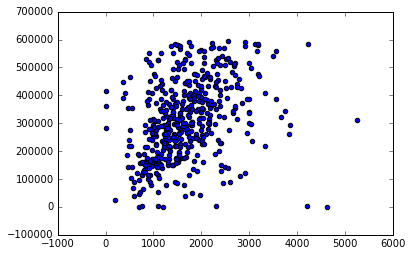

In [112]:
no_na = n_df.loc[(n_df['Floor size: '] >0) & (n_df['Sold Price'] >0)]
x = no_na['Floor size: '].tolist()
y = no_na['Sold Price'].tolist()
plt.scatter(x, y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print r_value**2

0.611930790204


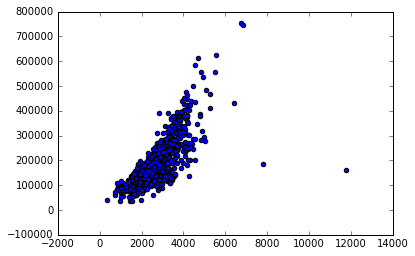

In [115]:
x = final_int_train['TotalSF']
y = train['SalePrice']
plt.scatter(x,y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print r_value**2

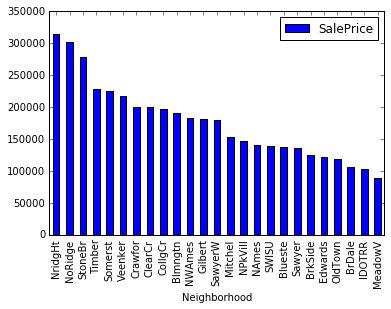

In [410]:
cat[['Neighborhood', 'SalePrice']].groupby('Neighborhood').median().sort_values(['SalePrice'], ascending = [0]).plot.bar()